# Катастрофа титаника.
Изучим [данные](https://www.kaggle.com/competitions/titanic) по трагедии Титаника и попытаемся разработать модель предсказания, выживет ли пассажир на корабле или нет.
<br> Воспользуемся одним из типовых методов решения задач с помощью машинного обучения - [градиентный бустинг](https://en.wikipedia.org/wiki/Gradient_boosting) на [случайном лесе](https://en.wikipedia.org/wiki/Random_forest).
<br>*(да-да, ансамбль ансамблей - это то, что доктор прописал!)*

## Изучим и предобработаем данные.

Загрузим все нужные библиотеки и изучим имеющиеся данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(0)

titanic_df = pd.read_csv("titanic.csv")
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Наблюдаем, что в нашей выборке есть 891 наблюдение (записей о пассажирах) и 12 признаков, описывающих пассажиров. Взглянем на типы этих признаков.

In [2]:
titanic_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Видим, что наш датасет содержит как численные переменные, так и категориальные. Разберемся с категориальными типами позже.

Сформируем входные и выходные данные:

Очевидным образом, не все признаки нам пригодятся для построения модели. Нам вряд ли пригодится знать идентификатор пассажира, его номер билета, номер комнаты в которой он пребывал или его имя, т.к. они являются исключительно индивидуальными чертами каждого наблюдения. Мы же в свою очередь стараемся выявить некоторые общие правила, которые характеризуют возникновение того или иного результата, и признаки с их степенью важности, которые могут повлиять на результат.

Удалим все ненужные переменные:

In [3]:
titanic_df = titanic_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1) 

Теперь взглянем на наши пустые значения в выборке.

In [4]:
print(f"Количество пустых значений: \n{titanic_df.isnull().sum()}")

Количество пустых значений: 
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


Как мы можем видеть, к сожалению пустые значения в данных присутствуют. Наверное, они были утеряны исследователями во время сбора информации о пассажирах, а может такой информации и вовсе не было у администрации корабля. Как бы то ни было, пустые значения необходимо заполнить. Нулями мы их заполнять не станем, но для каждого признака сделаем заполнение по умному.

In [5]:
# Переменную Embarked заполним тем значением, которое встречается чаще всего (т.е. модой).
titanic_df.Embarked = titanic_df.Embarked.fillna(titanic_df.Embarked.mode()[0])

# Переменную Age заполним по медианному значения возраста.
titanic_df.Age = titanic_df.Age.fillna(titanic_df.Age.median())

print(f"Количество пустых значений: \n{titanic_df.isnull().sum()}")

Количество пустых значений: 
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


Также мы все еще имеем некоторые переменные, представленные в категориальном виде, а не в численном. Переведем все категориальные переменные в численные с помощью one-hot энкодинга.

In [6]:
titanic_df = pd.get_dummies(titanic_df)
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


Удалим лишние столбцы, сформировнные с помощью метода get_dummies().

In [7]:
titanic_df = titanic_df.drop(["Sex_female", "Embarked_Q"], axis=1)
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,True,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


Теперь взглянем на историю, которую показывают наши данные. Возможно мы сумеем отыскать какие нибудь интересные зависимости.

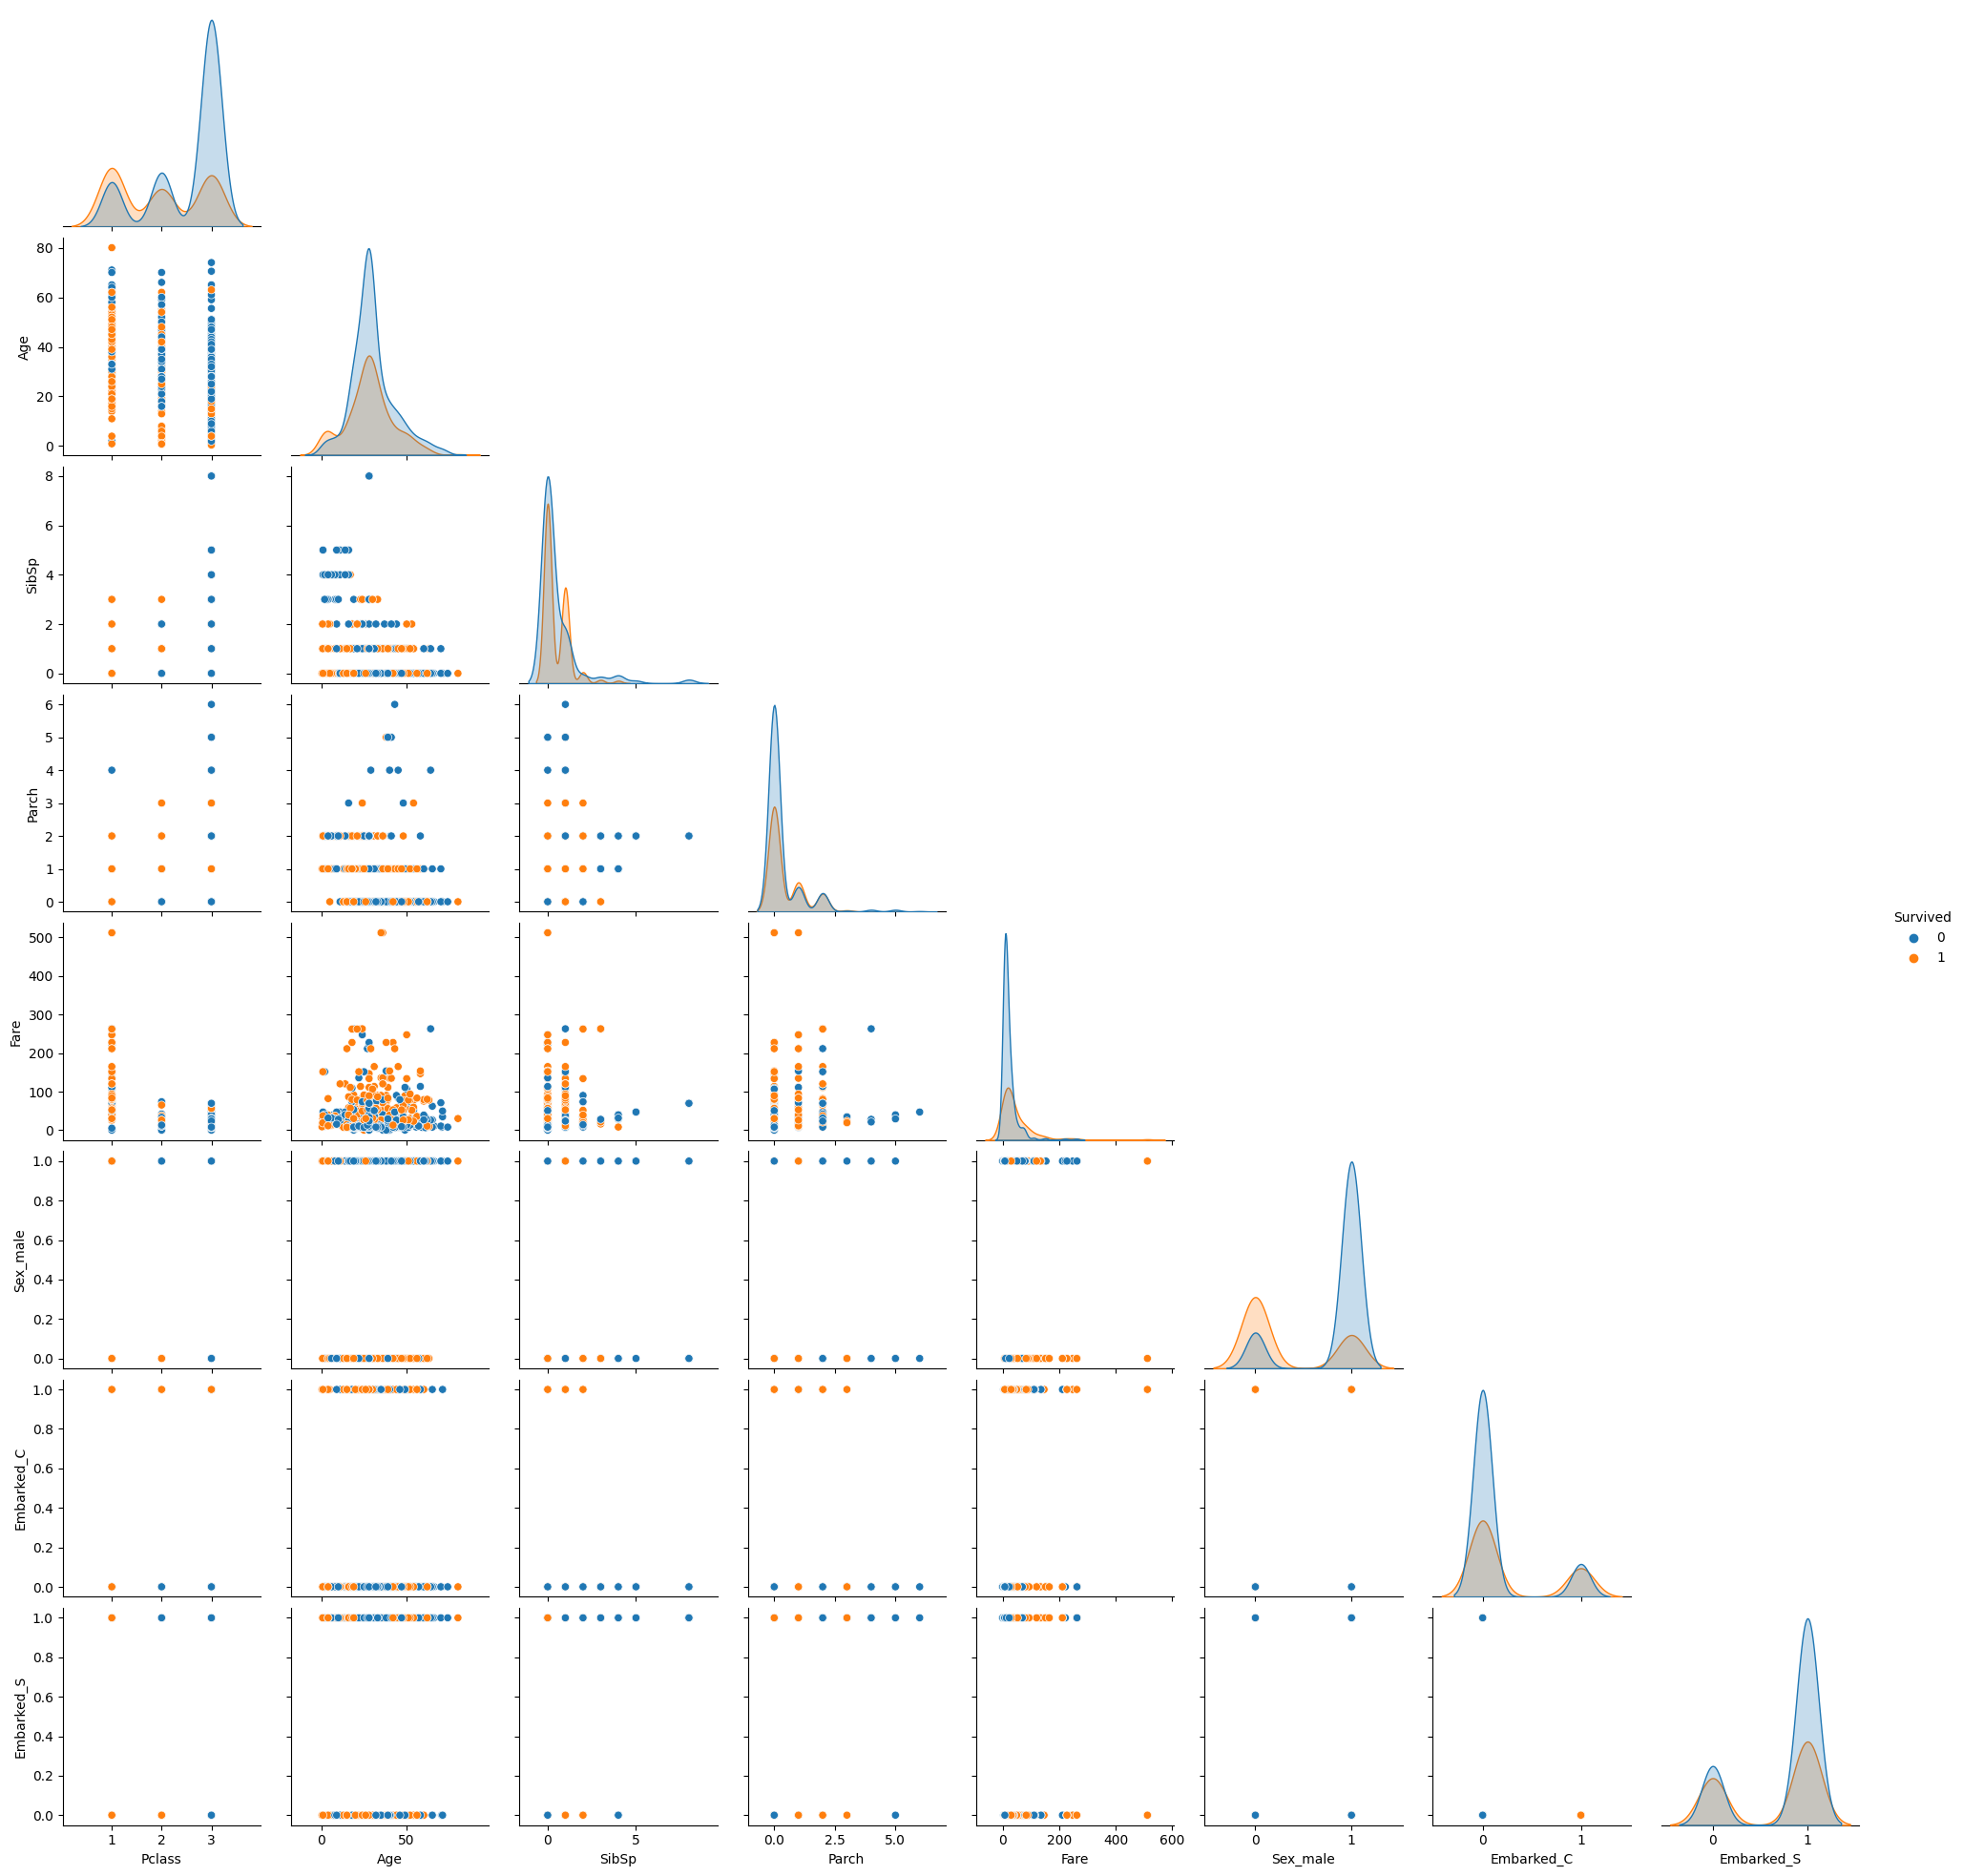

In [8]:
sns.pairplot(data=titanic_df, hue="Survived", corner=True)

Глядя на эту таблицу, мы уже можем сделать некоторый вывод о том, как факт выживания зависит от некоторых переменных. Например:
1. Пассажиры в первом классе в абсолютном измерении выживают чаще, чем во втором и третьем классе. А пассажиры во втором классе в процентном соотношении выживают чаще, чем в третьем.
2. Мужчины выживают реже, чем женщины.
<br>и т.д.
<br>Обучим на наших данных модель.

Сформируем тестовые и тренировочные датасеты.

In [9]:
X = titanic_df.drop(["Survived"], axis=1)
y = titanic_df.Survived

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Мы провели предобработку данных. Теперь мы можем с уверенностью начать работать с обучением моделей на этих данных.
## Обучим модель и сделаем предсказание

In [10]:
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from xgboost import XGBRFClassifier

parameters = {
    "n_estimators": range(10, 101, 10),
    "max_depth": range(2, 11, 2),
    "learning_rate": [0.3, 0.5, 0.7, 1],
}

clf = XGBRFClassifier()
cv  = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
search = RandomizedSearchCV(clf, parameters, cv=cv, n_jobs=-1)

search.fit(X_train, y_train)
best_clf = search.best_estimator_
y_pred = best_clf.predict(X_test)


Взглянем на полученные метрики.

In [11]:
from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score
)

scores = pd.DataFrame({
    "Accuracy": [accuracy_score(y_test, y_pred)],
    "Precision": [precision_score(y_test, y_pred)],
    "Recall": [recall_score(y_test, y_pred)],
    "F1-score": [f1_score(y_test, y_pred)],
    "ROC AUC score": [roc_auc_score(y_test, y_pred)]
})

scores.index = ["Score"]
scores

,Accuracy,Precision,Recall,F1-score,ROC AUC score
Score,0.849162,0.888889,0.695652,0.780488,0.820553


Достанем лучшие найденные параметры для случайного леса.

In [12]:
best_params = search.best_params_
for key, value in best_params.items():
    best_params[key] = [value]

best_params = pd.DataFrame(best_params)
best_params.index = ["Value"]
best_params

,n_estimators,max_depth,learning_rate
Value,90,8,1


Взглянем на важность тех или иных признаков, которую сформировал для себя бустинг:

In [13]:
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({
    "features": list(X),
    "feature_importances": feature_importances    
})

feature_importances_df.sort_values("feature_importances", ascending=False)

,features,feature_importances
5,Sex_male,0.731179
0,Pclass,0.126018
7,Embarked_S,0.038245
2,SibSp,0.036022
4,Fare,0.020334
1,Age,0.018941
6,Embarked_C,0.014857
3,Parch,0.014404


Как мы можем заметить, действительно пол и класс пассажира влияют на выживание, причем пол пассажира с разительной большой важностью.

## Результат на Kaggle
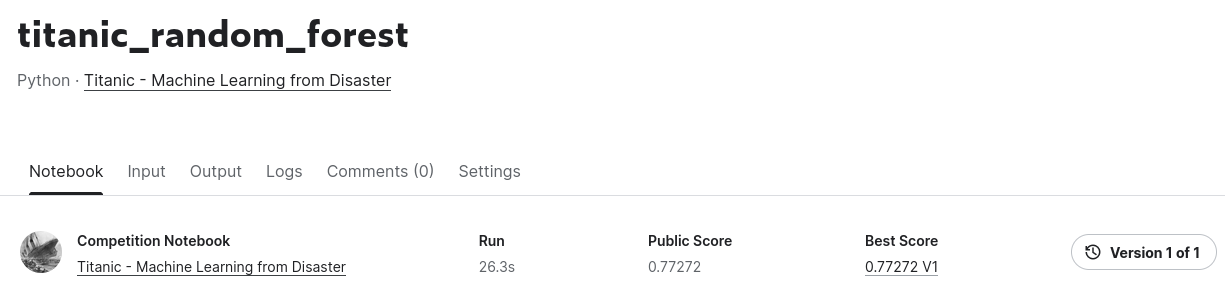
<br><br>*Примерно тот же результат и получился